1. 이미지 출력 편리를 위한 함수 정의<br>

2. Threshold(이미지를 2개의 색상으로 구별)<br>

3. Adaptive Threshold(블록단위 Threshold를 구함)

#### ※ 참고사항 : 이미지 Processing에 대한 사고처리방법
1. cv2.imread() : 이미지를 읽은 후에 반드시 흑백으로 변환하라.
2. 이미지에 대한 전처리를 수행한다.
    * 가우시안 블러링, 미디언블러를 통한 이미지 전처리
    * filter size 고려
    
> 2번과 3번은 경우에 따라 뒤바뀌기도 한다.

3. 문제 풀이에 대한 방법론을 찾는다.
    - binary processing - 이미지를 특정 값을 기준으로 0과 1로 나눈다.<br> (컴퓨터가 이해하기 쉬운 흑백으로 구분)
    - contour를 사용함으로써 edge에 대해 검출
4. 문제에 대한 결과를 이미지로 표현한다.

In [1]:
import scipy.stats as sp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)

### 1. 이미지 출력 편리함을 위한 함수 정의

In [2]:
def imshow(title, image):
    plt.title(title)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')

    plt.show()

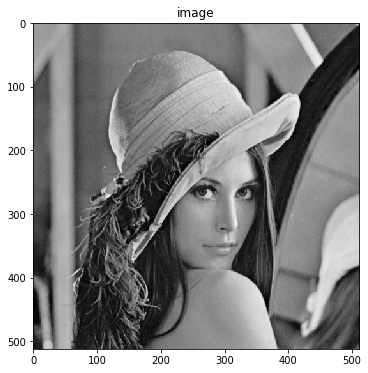

In [3]:
image = cv2.imread("./datas/Lena.png", 0) # 0은 흑백으로 읽으라는 뜻
imshow("image", image)

### 2. Threshold에 대해 알아보도록 하자
* 2진 함수의 밝기를 보고 검정색이나 흰색으로 만듬
* 역치를 기준으로 이진의 검정과 흰색으로 구분, 가장 단순
* threshold는 2개의 output을 반환한다.(Threshold값과 변환된 이미지)

#### ※ 참고사항 : Threshold 함수 설명
cv2.threshold(*src, threshold_value, value, flag) → retval, dst

Parameters:	
- **src** – input image로 single-channel 이미지.(**grayscale** 이미지만 가능!!!)
- **threshold_value** – 임계값
- **value** – 임계값을 넘었을 때 적용할 value
- **flag** – thresholding type
    - *cv2.THRESH_BINARY* : threshold보다 크면 value이고 아니면 0으로 바꾸어 준다. 
    - *cv2.THRESH_BINARY_INV* : threshold보다 크면 0이고 아니면 value로 바꾸어 준다. 
    - *cv2.THRESH_TRUNC* : threshold보다 크면 value로 지정하고 작으면 기존의 값 그대로 사용한다.
    - *cv2.THRESH_TOZERO* : treshold_value보다 크면 픽셀 값 그대로 작으면 0으로 할당한다.
    - *cv2.THRESH_TOZERO_INV* : threshold_value보다 크면 0으로 작으면 그대로 할당해준다. 
    
------------------------------------------------------
Return Values :
- **retval** : 입력한 임계값(threshold_value)
- **dst** : 임계값 이미지

#### 예시 1. Lena image

Threshold used :  128.0
Result :  [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


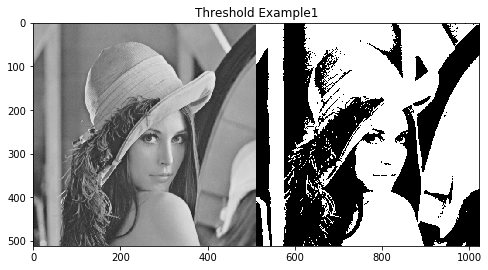

In [4]:
img = cv2.imread("./datas/Lena.png", 0)

thr, mask = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
print("Threshold used : ", thr)
print('Result : ', mask)

images = np.hstack([img, mask])
imshow("Threshold Example1", images)

#### 예시 2. Circle Image
* circle 이미지에 noise가 있기에 유의(필요 시 noise 제거하는 블러처리)
* circle 이미지는 배경과 전경의 명암 대비가 매우 큼

> 필터의 <strong>`크기`, `역치(threshold)`의 값 설정</strong>에 대한 센스 터득을 하자!

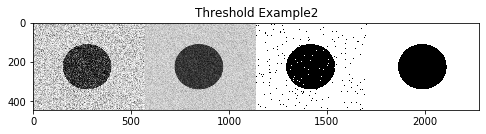

In [5]:
img = cv2.imread("./datas/circle.png", 0)

# noise가 많이 들어가 있는 이미지 파일이기에 noise 제거 작업 선 수행 필요
img_blur = cv2.GaussianBlur(img, (5,5), 0)


# 만약 noise를 제거하지 않으면 다음과 같은 이미지가 나온다.
_, wrong = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

# 이진화 필요
_, binary = cv2.threshold(img_blur, 128, 255, cv2.THRESH_BINARY)

# 시각화
images = np.hstack([img, img_blur, wrong, binary])
imshow("Threshold Example2", images)

#### 예시 3. rectangle image

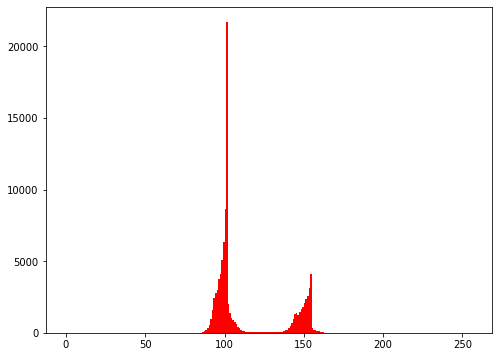

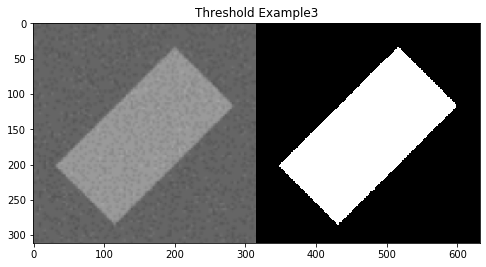

In [6]:
img = cv2.imread("./datas/boxnoise.PNG", 0)

# threshold값을 정하기위한 pixel 값을 확인하자.
plt.hist(img.ravel(), 256, [0, 256], color ='r')
plt.show()

# 임계값을 120으로 setting
_, binary = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)

images = np.hstack([img, binary])
imshow("Threshold Example3", images)

#### 예제 4. 흐릿해지는 이미지(Wrong Way)
* THRESH_BINARY의 경우에는 Threshold가 1개이기에, 흐릿해지는 이미지를 구할 수가 없다. 따라서 <strong>`AdaptiveThreshold`</strong>를 통해 블럭 단위의 역치를 구하자!

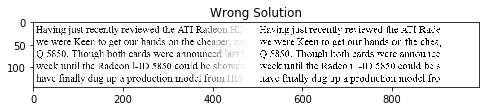

In [7]:
img = cv2.imread("./datas/ocr03.png", 0)

_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

images = np.hstack([img, binary])
imshow("Wrong Solution", images)

### 3. 블록 단위 Theshold를 구하는 Adaptive Threshold
* n개의 블록(pixel)을 나누고 역치를 찾는다.
* 따라서 adaptive는 locality(지역적인) 의미를 띈다.

> binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 21, 2)<br>
  <br>
* cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 가우시안 평균(평균과 가까울수록 가중치가 크다. ex. 평균 근처 가중치 2/3 먼쪽 1/6)<br>
    ** 어떠한 measure를 사용할지 모르겠다 싶으면 가우시안 평균을 사용!
* 21 : 21개의 pixel을 한 블록으로 사용하겠다.
* 2 : threshold 값으로부터 -2만큼 이동하겠다. 평균보다 높게할지 작게할지 결정한다.(평균이 너무 이상적이기에 움직여서 사용, 양수이면 역치값을 왼쪽으로, 음수이면 역치값을 오른쪽으로 이동)

<br>
* <strong>THRESH_OTSU</strong> : Otsu의 이진화(Otsu’s Binarization)란 bimodal image에서 임계값을 자동으로 계산해주는 것을 말한다.


#### 예제 1. 흐릿해지는 이미지(Right Way)

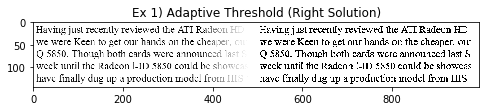

In [8]:
img = cv2.imread("./datas/ocr03.png", 0)
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 21, 2)

images = np.hstack([img, binary])
imshow("Ex 1) Adaptive Threshold (Right Solution)", images)

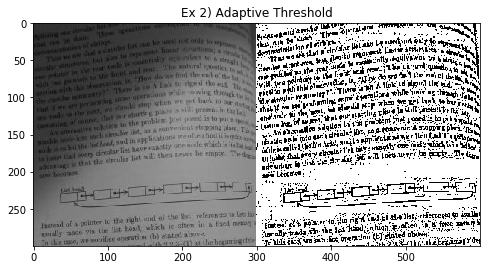

In [9]:
img = cv2.imread("./datas/text.jpg", 0)

binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 11, 2)

images = np.hstack([img, binary])
imshow("Ex 2) Adaptive Threshold", images)

#### 예제 2. 스도쿠 image

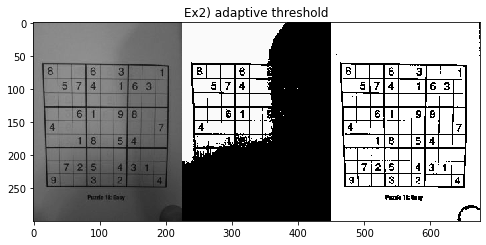

In [10]:
img = cv2.imread("./datas/grid.jpg", 0)

# 이미지에 그림자가 많아서 일부의 내용이 잘리게 된다.
_, wrong = cv2.threshold(img, 120, 250, cv2.THRESH_BINARY)

binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 31, 5)

images = np.hstack([img, wrong, binary])
imshow("Ex2) adaptive threshold", images)

#### 참고사항) THRESH_OTSU를 사용한 잘못된 예제

(300, 225)


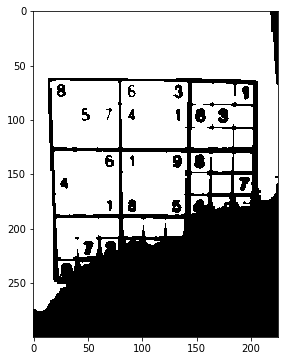

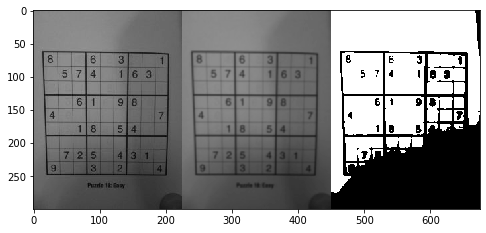

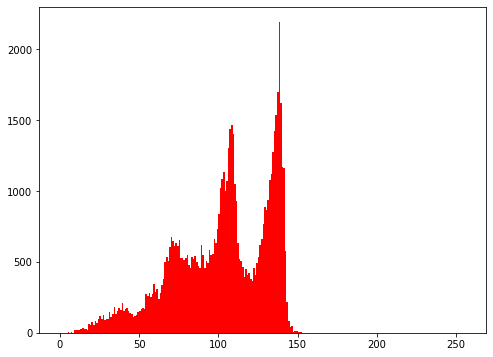

In [11]:
#### THRESH_OTSU를 사용한 잘못된 예제
image = cv2.imread("./datas/grid.jpg", 0)
print(image.shape)

img_blur = cv2.GaussianBlur(image, (5,5), 0)
_, binary = cv2.threshold(
    img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow("", binary)

imshow("", np.hstack([image, img_blur, binary]))
plt.hist(image.ravel(), 256, [0,256], color='r')
plt.show()

#### 예제 3. 영수증 image

(800, 600)


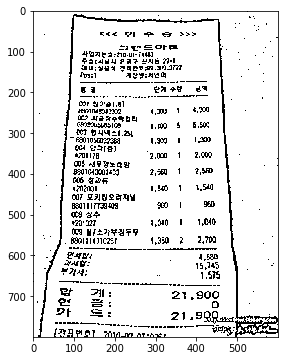

In [12]:
image = cv2.imread("./datas/receipt04.png", 0)
print(image.shape)

image_blur = cv2.GaussianBlur(image, (5,5), 0)
binary = cv2.adaptiveThreshold(image_blur, 255,
                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                          cv2.THRESH_BINARY, 21, 5)

cv2.imwrite("output.jpg", binary)
imshow("", binary)

(800, 600)


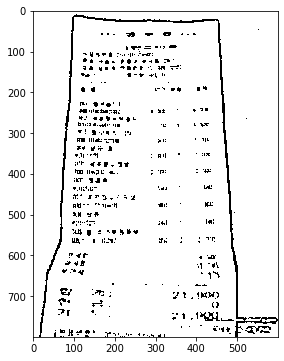

In [13]:
# median 으로 제거 안되면 중앙값으로나 평균값으로나 빠지지 않으니 sparse noise리거 한다.
#한두개가 튀는게 아니다.
image = cv2.imread("./datas/receipt04.png", 0)
print(image.shape)

image_blur = cv2.medianBlur(image, 7)
binary = cv2.adaptiveThreshold(image_blur, 255,
                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                          cv2.THRESH_BINARY, 21, 5)

cv2.imwrite("output.jpg", binary)
imshow("", binary)

(800, 600)


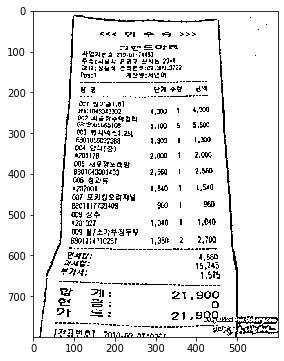

In [14]:
image = cv2.imread("./datas/receipt04.png", 0)
print(image.shape)

image_blur = cv2.GaussianBlur(image, (5,5), 0)
binary = cv2.adaptiveThreshold(image_blur, 255,
                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                          cv2.THRESH_BINARY, 21, 7)

cv2.imwrite("output.jpg", binary)
imshow("", binary)

#### 참고사항 : 바둑돌 문제(사고확장!!)
<strong>&nbsp;&nbsp; - 이진 threshold로 접근해서는 안된다.</strong>

(448, 498)


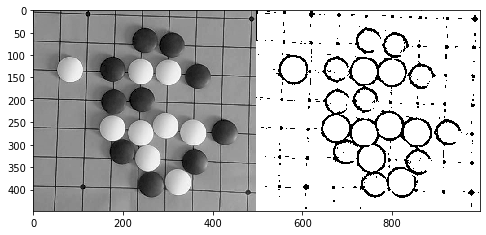

In [15]:
# threshold로 해결하는 문제는 아니다. (검은돌, 흰돌)
image = cv2.imread("./datas/stone.png", 0)
print(image.shape)

image_blur = cv2.medianBlur(image, 7)
binary = cv2.adaptiveThreshold(image_blur, 255,
                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                          cv2.THRESH_BINARY, 21, 5)

cv2.imwrite("output.jpg", binary)
images = np.hstack([image, binary])
imshow("", images)

#### 예제 4, 도형들
<strong>&nbsp;&nbsp; - 원을 검출할 때는 무수히 많은 점들로 이루어진 다각형으로 생각하고 접근해야 한다.</strong>

(584, 898)


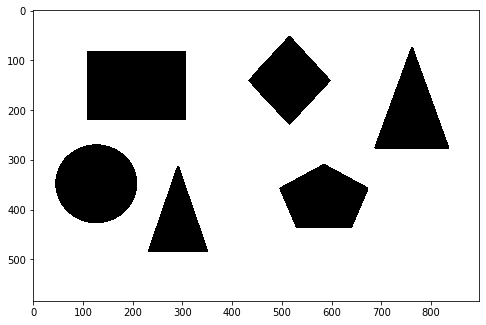

In [16]:
#원을 검출할 때 무수히 많은 점들로 이루어진 다각형으로 생각하고 찾는다.

img = cv2.imread("./datas/shape3.png", 0)
print(img.shape)

thr, mask = cv2.threshold(img,0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)

imshow("", mask)

In [ ]:
image = cv2.imread("../datas/mart2.jpg", 0)
img_blur = cv2.GaussianBlur(image, (21,21), 0)
_, binary = cv2.threshold(img_blur, 120, 255, cv2.THRESH_BINARY)
imshow("", img_blur)
imshow("", binary)


In [ ]:
image = cv2.imread("../datas/mart2.jpg", 0)
img_blur = cv2.GaussianBlur(image, (21,21), 0)
_, binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow("", img_blur)
imshow("", binary)

In [ ]:
image = cv2.imread("../datas/mart2.jpg", 0)
img_blur = cv2.GaussianBlur(image, (21,21), 0)
binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY,101,2)
imshow("", img_blur)
imshow("", binary)

In [ ]:
# 영수증 안에 채워야할것이 많기에 closing 사용